In [1]:
%matplotlib inline

# imports
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import os

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

In [221]:
# load psd, fooof & dfa results
def load_results(basefolder, filename, load_psd=True, load_fooof=True, load_dfa=True):
    psd_data, fooof_data, dfa_data = [], [], []
    if load_psd:
        psd_data = np.load(basefolder+'psd/'+filename)
        print(list(psd_data.keys()))
    if load_fooof:
        fooof_data = np.load(basefolder+'psd/fooof/'+filename)
        print(list(fooof_data.keys()))
    if load_dfa:    
        dfa_data = np.load(basefolder+'dfa/'+filename)
        print(list(dfa_data.keys()))
    
    return psd_data, fooof_data, dfa_data


def load_fooof_results(basefolder, filename):
    fooof_data = np.load(basefolder+filename)
    print(list(fooof_data.keys()))
    return fooof_data

def tau_from_C(knee):
    return np.sqrt(1/knee)/(2*np.pi)

def nan_95(x):
    return 1.96*np.nanstd(x)/(x.shape[0]-sum(np.isnan(x)))**0.5

def plot_ts_correlations(ecog_ts, cell_ts, marker, ms=12, plot_cf=True, show_legend=True):    
    for i,key in enumerate(cell_ts.keys()):
        curr_c=CKEYS[C_ord[i]]
        if plot_cf:
            plt.errorbar(cell_ts[key][0], ecog_ts[key][0], ecog_ts[key][1],cell_ts[key][1], fmt=marker, ms=ms, label=key, color=curr_c)
        else:
            plt.plot(cell_ts[key][0], ecog_ts[key][0], marker, ms=ms, label=key, color=curr_c)
    
    if show_legend: plt.legend()
    plt.xlabel('Single Unit Time Constant (s)')
    plt.ylabel('ECoG Time Constant (s)')

    # stats on grand average
    ts_means = np.array([[cell_ts[key][0], ecog_ts[key][0]] for key in cell_ts.keys()])
    XL = np.array(plt.xlim())
    try:
        W = np.polyfit(ts_means[:,0],ts_means[:,1],1)
    except:
        print('Regression did not converge.')
        W = [0.,0.]
    
    plt.plot(XL, XL*W[0]+W[1], 'k--', lw=1)
    rho,pv = sp.stats.pearsonr(ts_means[:,0], ts_means[:,1])
    print('rho=%.3f, p-value=%.3f, TS factor=%0.3f'%(rho,pv,W[0]))

![](../../img/chibi_murray.png)

In [238]:
# loading all fooof results
fooof_path = '/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/'
fooof_files = sorted([ff for ff in os.listdir(fooof_path) if '.npz' in ff])
conds = ['EyesOpen', 'EyesClosed', 'Delivery', 'Anesthesia']
cond = conds[0]
fit_type = 'bg_kn_med' #bg_kn, bg_kn_med
fit_feat = 'knee'

fits, subj = [],[]
for ff in fooof_files:
    metadata = [ff.split('_')[i] for i in [1,2,3,7]]
    if cond in metadata:
        fooof_data=np.load(fooof_path+ff)
        fits.append(fooof_data[fit_type])
        subj.append(metadata[-1])
            
fits = np.dstack(fits)

# collect data from electrodes
cell_ts = {'MT':[77.,64.], 'LIP':[138., 91.], 'LPFC':[184.,180.,195.,162.], 'OFC':[176.,188.], 'ACC':[313.,340.,257.], 'S1':[65.], 'S2':[149.]}
cell_ts_avg = {}

# consult map for these coords
loc_inds_chibi = {'MT':[3,4,109], 'LIP':[10,11], 'LPFC':[14,15,25,26], 'OFC':[23,34,45], 'ACC':[52,57,58,59], 'S1':[9,19], 'S2':[95,108]}
loc_inds_george = {'MT':[4,13,22], 'LIP':[10,11,20,21], 'LPFC':[15,24,25,26], 'OFC':[45,66], 'ACC':[52,57,58,59], 'S1':[18,19,30], 'S2':[1,2,9,108]}
loc_inds = {'Chibi': loc_inds_chibi, 'George': loc_inds_george}

# collect all data
ecog_ts = {}
ecog_ts_avg = {}
for i,key in enumerate(cell_ts.keys()):
    ecog_ts[key]=[]
    for rec in range(fits.shape[2]):
        cur_locs = np.array(loc_inds[subj[rec]][key])-1
        if fit_feat is 'knee':
            ecog_ts[key].append(tau_from_C(fits[cur_locs,1,rec])*1000)
        elif fit_feat is 'slope':
            ecog_ts[key].append(fits[cur_locs,-1,rec])

    # average over all electrodes within a single recording
    ecog_ts_avg[key] = np.array([[np.nanmean(ts), nan_95(ts)] for ts in ecog_ts[key]])
    cell_ts_avg[key] = np.array([np.mean(cell_ts[key]), nan_95(np.array(cell_ts[key]))])

# average over session and subject
per_session = [{key: ecog_ts_avg[key][rec,:] for key in ecog_ts_avg.keys()} for rec in range(len(subj))]
monkeys, subj_ind = np.unique(subj, return_inverse=True) # get subject indices
per_subj = [{key: np.array([np.nanmean(ecog_ts_avg[key][subj_ind==s,0]), nan_95(ecog_ts_avg[key][subj_ind==s,0])]) for key in ecog_ts_avg.keys()} for s in np.unique(subj_ind)]    
    
# grand average: average over all sessions
ecog_ts_grandavg = {key: [np.nanmean(ecog_ts_avg[key][:,0]), nan_95(ecog_ts_avg[key][:,0])] for key in ecog_ts_avg.keys()}

# plotting params
C_ord = [3,1,2,0,4,6,5]
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers=['D','v']

Grand Average
rho=0.856, p-value=0.014, TS factor=0.096
Subject Average
rho=0.950, p-value=0.001, TS factor=0.058
rho=0.742, p-value=0.056, TS factor=0.134
Per Session
rho=0.743, p-value=0.056, TS factor=0.118
rho=0.848, p-value=0.016, TS factor=0.111
rho=0.825, p-value=0.022, TS factor=0.100
rho=0.622, p-value=0.136, TS factor=0.206
rho=0.959, p-value=0.001, TS factor=0.099
rho=0.961, p-value=0.001, TS factor=0.059
rho=0.889, p-value=0.007, TS factor=0.053
rho=0.815, p-value=0.026, TS factor=0.020


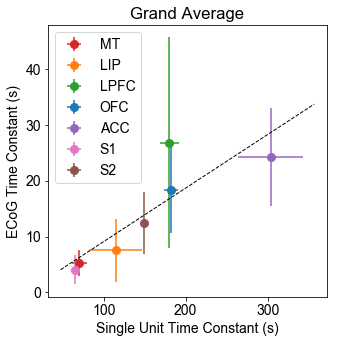

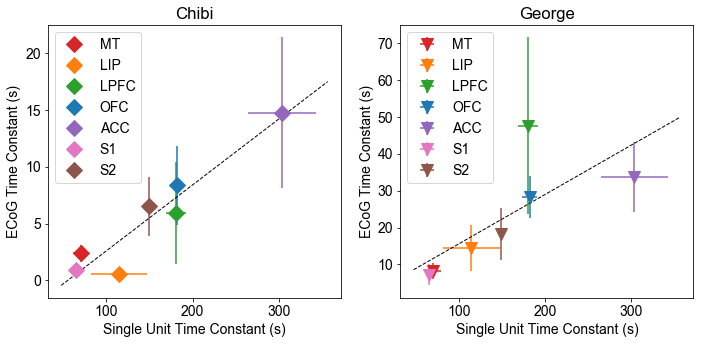

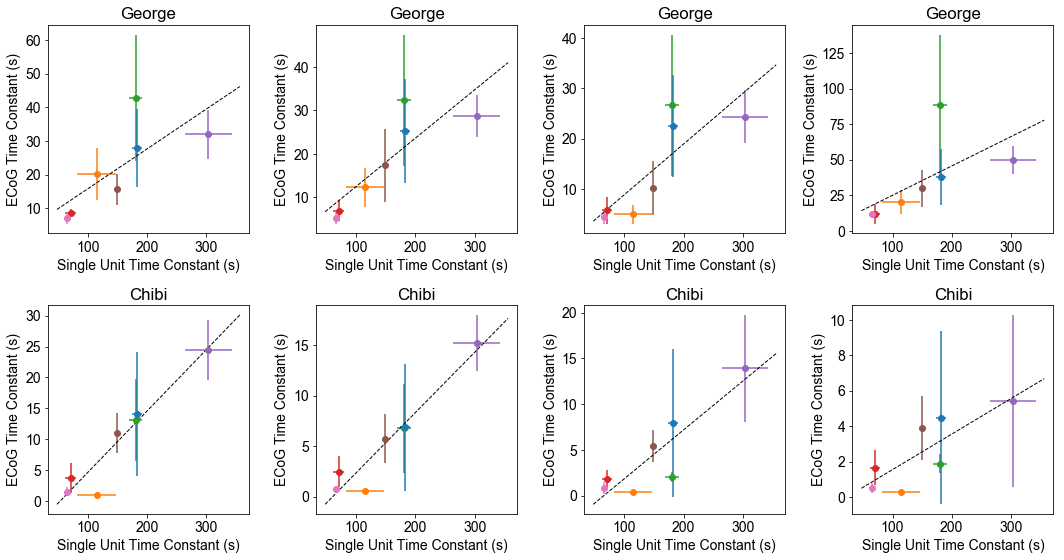

In [239]:
print('Grand Average')
plt.figure(figsize=(5,5))
plot_ts_correlations(ecog_ts_grandavg, cell_ts_avg, marker='o', ms=8)
plt.title('Grand Average');

print('Subject Average')
plt.figure(figsize=(10,5))
for s in range(2):
    plt.subplot(1,2,s+1)
    plot_ts_correlations(per_subj[s], cell_ts_avg, marker=markers[s])
    plt.title(monkeys[s])
plt.tight_layout()

print('Per Session')
sess_sorted = np.hstack((np.where(np.arange(len(subj))[subj_ind]), np.where(np.arange(len(subj))[1-subj_ind])))[0]
plt.figure(figsize=(15,8))
for exp in range(fits.shape[2]):
    plt.subplot(2,4,exp+1)
    plot_ts_correlations(per_session[sess_sorted[exp]], cell_ts_avg, marker='.', show_legend=False)
    plt.title(subj[sess_sorted[exp]])
plt.tight_layout()

# Macaque ECoG vs. Spiking Timescale
Single unit spiking timescale correlates with ECoG characteristic timescale across cortical areas. More generally, timescale increases moving from posterior to anterior regions of the brain, "up the cortical hierarchy".

However, there is a conversion factor of ~0.1 from ECoG to spiking, i.e. ECoG timescale is 1/10 of single unit spike timing timescale. Why is that?
1. timescale correlation is due to chance, or some other factor in the ECoG, e.g., dendritic/membrane integration constant
2. spiking is local output, whereas ECoG is (mostly) input, so the time constant measured in ECoG is spiking from the afferent region
3. single unit time constant is different from population time constant, which has been proposed as the benefit of asynchronous population spiking (faster reaction, e.g., van Vreeswijk, Destexhe)
4. local recurrent dendritic processes "filter" spiking, most likely in a low-pass fashion. Thus, whatever process with the highest time constant (lower frequency knee) will dominate in the retrieved timescale
5. they have nothing to do with each other and this is just random

**Should try gamma or broadband power autocorrelation over time to match with the spiking timescale.**

# Slope vs. Knee
Current points of investigation:
- Median fit knee is most consistent in correlating with timescale, and in general, produces more robust fits for the PSD (less nans, i.e., negative knees).

- When fit with knee, slope also (negative) correlates with single unit time constant. However, when just fit using a line in the full range, slope does NOT correlate with time constant. This is surprising, as I would have expected the knee-removed slope to be independent of the timescale, and the non-knee-removed slope fits are essentially corrupted by the knee. This indicates that the characteristic timescale (in exponential decay) is correlated with the power-law decay (???), suggesting multiple processes with multiple temporal time characteristics.

- For example, exponential decay constant (knee) may arise from synaptic time constant, while the power law relation may be from population spiking autocorrelation.

- need to check this with just linear range fits.

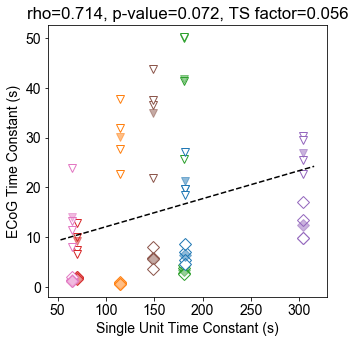

In [84]:
_, subj_ind = np.unique(subj, return_inverse=True) # get subject indices
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers=['D','v']

#plotting
C_ord = [3,1,2,0,4,6,5]
plt.figure(figsize=(5,5))
for i,key in enumerate(cell_ts.keys()):
    curr_c=CKEYS[C_ord[i]]
    for s in np.unique(subj_ind):
        plt.plot(cell_ts_avg[key][0]*np.ones(sum(subj_ind==s)), ecog_ts_avg[key][subj_ind==s,0], markers[s], alpha=1, ms=8, mfc='w',color=curr_c)
        plt.plot(cell_ts_avg[key][0], ecog_ts_avg[key][subj_ind==s,0].mean(), markers[s], alpha=0.5, ms=8, color=curr_c)
#    plt.plot(cell_ts_avg[key][0], ecog_ts_avg[key][:,0].mean(), 'o', ms=12, label=key, color=curr_c)
#    plt.errorbar(cell_ts_avg[key][0], ecog_ts_avg[key][:,0].mean(),ecog_ts_avg[key][:,0].std(),cell_ts_avg[key][1], 'o', ms=12, label=key, color=curr_c)


plt.legend()
plt.xlabel('Single Unit Time Constant (s)')
plt.ylabel('ECoG Time Constant (s)')

# stats on grand average
ts_means = np.array([[cell_ts_avg[key][0], ecog_ts_avg[key][:,0].mean()] for key in cell_ts.keys()])
W = np.polyfit(ts_means[:,0],ts_means[:,1],1)
XL = np.array(plt.xlim())
plt.plot(XL, XL*W[0]+W[1], 'k--')
rho,pv = sp.stats.pearsonr(ts_means[:,0], ts_means[:,1])
plt.title('rho=%.3f, p-value=%.3f, TS factor=%0.3f'%(rho,pv,W[0]));